In [1]:
from datasets import load_dataset
from tqdm import tqdm
from datasets import Dataset
import torch 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import tqdm
from tqdm import trange, tqdm
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix
import os 
from PIL import Image
import torchvision

/rds/general/user/ojf24/home/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
!pip uninstall -y torch torchvision

Uninstalling torch-1.1.0:
ERROR: Exception:
Traceback (most recent call last):
  File "/apps/jupyterhub/2019-04-29/miniconda/lib/python3.6/shutil.py", line 550, in move
    os.rename(src, real_dst)
OSError: [Errno 18] Invalid cross-device link: '/rds/general/applications/jupyterhub/2019-04-29/miniconda/lib/python3.6/site-packages/caffe2' -> '/var/tmp/pbs.863968.pbs/pip-uninstall-rz6zdgtu'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/apps/jupyterhub/2019-04-29/miniconda/lib/python3.6/site-packages/pip/_internal/cli/base_command.py", line 178, in main
    status = self.run(options, args)
  File "/apps/jupyterhub/2019-04-29/miniconda/lib/python3.6/site-packages/pip/_internal/commands/uninstall.py", line 75, in run
    auto_confirm=options.yes, verbose=self.verbosity > 0,
  File "/apps/jupyterhub/2019-04-29/miniconda/lib/python3.6/site-packages/pip/_internal/req/req_install.py", line 825, in uninstall
    uninstalled_path

In [ ]:
ds_train = load_dataset("alkzar90/NIH-Chest-X-ray-dataset", 'image-classification', split = "train[:5000]") 

# we hold back our test data to be used purely for testing, not in the context of our training loop 
ds_test = load_dataset("alkzar90/NIH-Chest-X-ray-dataset", 'image-classification', split = "test[:2000]") 



In [2]:
from torch.nn import functional as F
from torch import optim 

from transformers import ViTForImageClassification
import torchmetrics 

import lightning as L

In [3]:
# continue using pytorch ligthing to fine tune model as per 

# https://towardsdatascience.com/how-to-fine-tune-a-pretrained-vision-transformer-on-satellite-data-d0ddd8359596/#:~:text=Under%20the%20hood%2C%20the%20trainer,is%20completed%20within%20few%20epochs.


class VisionTransformerPretrained(L.LightningModule): 
    '''wrapper for the pretrained vision transformers'''

    def __init__(self, model = "google/vit-base-patch16-224", num_classes = 15, learning_rate = 1e-4):

        super().__init__()
        self.learning_rate = learning_rate 
        self.num_classes = num_classes
        backbone = ViTForImageClassification.from_pretrained(model, 
                                                             num_labels = num_classes, 
                                                             ignore_mismatched_sizes=True)
        
        self.backbone = backbone 

        self.loss_fn = nn.BCEWithLogitsLoss() # adjusted for our task of multilabel 

        #metrics 

        self.acc = torchmetrics.Accuracy("multilabel", num_labels=num_classes, threshold = 0.5)

        self.f1 = torchmetrics.F1Score(task="multilabel", num_labels=num_classes, average=None)  # Per-label F1
        self.precision = torchmetrics.Precision(task="multilabel", num_labels=num_classes, average=None)
        self.recall = torchmetrics.Recall(task="multilabel", num_labels=num_classes, average=None)
        self.accuracy = torchmetrics.Accuracy(task="multilabel", num_labels=num_classes, average=None)



    def forward(self, x): 
        return self.backbone(x).logits
    
    def step(self, batch, stage = "train"):
        '''Any step proccesses to return loss and predictions'''

        x, y = batch 

        logits = self.forward(x)
        y_hat = (torch.sigmoid(logits)>0.5).float() # we need to 

        loss = self.loss_fn(logits, y.float())
        acc = self.acc(y_hat, y)

        return loss, acc, y_hat, y
    
    def training_step(self, batch, batch_idx): 
        loss, acc, y_hat, y = self.step(batch)

        self.log("train_loss", loss)

        return loss 
    
    def validation_step(self, batch, batch_idx): 
        loss, acc, y_hat, y = self.step(batch)

        self.log("valid_acc", acc, on_epoch = True, on_step = False)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = 1e-4)
        return optimizer 



In [4]:
class HuggingFaceCXR(Dataset):
    """
    Custom PyTorch Dataset wrapper for Hugging Face datasets.
    Converts dataset samples into a PyTorch-compatible format.
    """
    def __init__(self, hf_dataset, image_size, num_classes=15, transform=None):
        self.dataset = hf_dataset.with_format("torch")  # Ensure dataset is in torch format
        self.image_size = image_size
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        # Load image
        image = item["image"]  # Ensure this matches your dataset keys

        # Resize image
        image = F.interpolate(image.unsqueeze(0), size = self.image_size, mode = "bilinear").squeeze(0)

        # Handle 4-channel (RGBA) images: Keep only RGB
        if image.shape[0] == 4:
            image = image[:3, :, :]

        # Handle Grayscale (1-channel) images: Convert to 3-channel
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        # Normalize pixel values to [0,1]
        image = image / 255.0

        # Convert labels to one-hot encoding
        labels = item["labels"]
        one_hot = torch.zeros(self.num_classes, dtype=torch.float32)
        one_hot[labels] = 1  # Set corresponding indices to 1

        # Apply optional transformations
        if self.transform:
            image = self.transform(image)

        return image, one_hot

In [5]:
import torch
import numpy as np

from sklearn.model_selection import train_test_split

from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

import lightning as L
from torch.utils.data import DataLoader, Subset

class nih_cxr_datamodule(L.LightningDataModule):
    '''Lightning data module for the cxr dataset'''

    def __init__(self, batch_size, data_root="alkzar90/NIH-Chest-X-ray-dataset"): 
        super().__init__()
        self.data_root = data_root
        self.batch_size = batch_size 
        self.num_classes = 15

    def setup(self, stage = None):
        '''set up the dataset, train/valid/test all at once'''

        transforms = v2.Compose([v2.ToImage(),
                                 v2.Resize(size=(224,224), interpolation=2),
                                 v2.Grayscale(num_output_channels=3), # need to ensure 3 channel grayscale for vit 
                                 v2.ToDtype(torch.float32, scale=True),
                                 v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                ])
        
        ds_train = load_dataset(self.data_root, 'image-classification', split = "train[:5000]")

        train_valid_split = ds_train.train_test_split(test_size = 0.2)

        ds_train = train_valid_split['train']
        ds_valid = train_valid_split['test']

 
        ds_test = load_dataset(self.data_root, 'image-classification', split = "test[:2000]") 

        self.train_data = HuggingFaceCXR(ds_train, image_size = (224, 224), transform = transforms)
        self.valid_data = HuggingFaceCXR(ds_valid, image_size = (224, 224), transform = transforms)
        self.test_data = HuggingFaceCXR(ds_test, image_size = (224, 224), transform = transforms)


    def train_dataloader(self): 
        return DataLoader(self.train_data, batch_size = self.batch_size, shuffle = True)
    
    def valid_dataloader(self): 
        return DataLoader(dataset = self.valid_data, batch_size = self.batch_size, shuffle = False)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size = self.batch_size, shuffle = False)
        

In [6]:
from sklearn.metrics import classification_report
def multi_label_evaluation(model, test_dataloader, test_dataset, logger): 
    model.eval()

    all_true_labels = []
    all_pred_logits = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc = "Collecting logits"): 
            x, y = batch 
            logits = model(x)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_true_labels.append(y.cpu().numpy())
            all_pred_logits.append(probs) # store these so we can assess different thresholds quickly 

    all_true_labels = np.vstack(all_true_labels)
    all_pred_logits = np.vstack(all_pred_logits)

    label_list = test_dataset.features['labels'].feature.names

    # now we try and find our best threshold before classificaiton report at that threshold 
    thresholds_to_test = np.linspace(0, 1, 10)
    f1_micro_list = []

    for value in thresholds_to_test:
        predictions = (all_pred_logits >= value).astype(int)
        report = classification_report(all_true_labels, predictions, target_names = label_list, output_dict = True)
        micro_f1_average = report['micro avg']['f1-score']
        f1_micro_list.append({"Threshold": value, "Micro-F1": micro_f1_average})

    # save micro f1 scores 
    log_dir = logger.log_dir

    os.makedirs(log_dir, exist_ok = True)
    f1_micro_path = os.path.join(log_dir, "f1_micro_average.csv")
    f1_micro_average_df = pd.DataFrame(f1_micro_list)
    f1_micro_average_df.to_csv(f1_micro_path, index = False)
   
    # now select the threshold that gave the highest micro average 

    best_threshold = f1_micro_average_df.loc[f1_micro_average_df["Micro-F1"].idxmax(), "Threshold"]

    # calculate final labels based on best threshold 

    all_pred_labels = (all_pred_logits >= best_threshold).astype(int)
    
    report_path = os.path.join(log_dir, f"test_multi_metrics_{best_threshold:.4f}.csv")
    final_report = classification_report(all_true_labels, all_pred_labels, target_names=label_list, zero_division=0, output_dict = True)
    pd.DataFrame(final_report).to_csv(report_path)




In [7]:

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger
from sklearn.metrics import classification_report

def main(args): 
    L.seed_everything(42)

    # set up data 
    datamodule = nih_cxr_datamodule(batch_size=8)
    datamodule.prepare_data()
    datamodule.setup()

    train_dataloader = datamodule.train_dataloader()
    valid_dataloader = datamodule.valid_dataloader()
    test_dataloader = datamodule.test_dataloader()

    # setup model 
    model = VisionTransformerPretrained('google/vit-base-patch16-224', datamodule.num_classes, learning_rate= 1e-4)

    early_stopping = EarlyStopping(monitor = 'valid_acc', patience = 6, mode = 'max')

    logger = CSVLogger("tensorboard_logs", name = 'nih_cxr_pretrained_vit')

    #train 
    trainer = L.Trainer(devices = 1, max_epochs = 10, callbacks = [early_stopping], logger =logger)
    trainer.fit(model = model, train_dataloaders=train_dataloader, val_dataloaders = valid_dataloader)

    # evaluate on the test set 
    
    # we want to set our threshold based on micro average due to class imbalance - use micro average f1 score 

    multi_label_evaluation(model, test_dataloader = test_dataloader, 
                           test_dataset = ds_test, logger = logger)
        

In [8]:
args = "arg"
run = main(args)

Seed set to 42
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
!nvidia-smi


In [7]:
import pandas as pd

training_metrics = pd.read_csv("/Users/oliverfox/git_repositories/nih_cxr_project/vit_pretrained_fine_tune/tensorboard_logs/nih_cxr_pretrained_vit/version_1/metrics.csv")
training_metrics.columns

Index(['epoch', 'step', 'train_loss', 'val_multi_label_f1'], dtype='object')

In [ ]:
training_metrics = training_metrics.groupby(training_metrics['epoch']).aggregate({'train_loss':'first', 'val_multi_label_f1':"first"})

,train_loss,val_multi_label_f1
epoch,,
0,0.342471,0.196633
1,0.233276,0.213044
2,0.127981,0.246632
3,0.244295,0.303175
4,0.098595,0.380172


<Axes: ylabel='train_loss'>

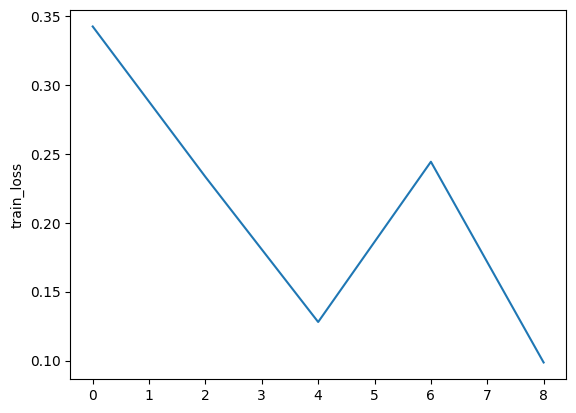

In [10]:
import seaborn as sns 

sns.lineplot(training_metrics['train_loss'])